In [1]:
from importlib import reload
import two_transmons.DoubleTransmonSystem
from two_transmons.DoubleTransmonSystem import *
import two_transmons.VacuumRabiSimulation
from two_transmons.VacuumRabiSimulation import *
import single_transmon.Transmon
from single_transmon.Transmon import *
from ReadoutResonator import *
from qutip import *
from tqdm.notebook import tqdm
from two_transmons.ZPulse import *
from importlib import reload
import two_transmons.ParallelCalculations
from two_transmons.ParallelCalculations import *
from two_transmons.CalcTime import *
from two_transmons.Tomography import *
from scipy.linalg import cholesky
from p_tqdm import p_map, p_imap
import time
import numpy as np
from numpy import dot
from copy import deepcopy
from transmon_chain.transmon_chain import *

In [2]:
Nc = 7
N_trunc = 3
Ec1 = 0.25 * 2 * np.pi
Ec2 = 1.03*Ec1
Ecc = 0.01/1.2**2 * 2 * np.pi # 1.2 is my estimate for n_{ge} matrix element
Ej1 = Ec1 * 100
Ej2 = Ec2 * 100
d = 0.2

T1_1, T2_1 = 10e6, 5e6
T1_2, T2_2 = 5e6, 1e6
T1_3, T2_3 = 5e6, 1e6
T1_4, T2_4 = 5e6, 1e6

tr1 = Transmon(Ec1, Ej1, d, 1/T1_1, 1/T2_1, Nc, N_trunc, 1)
tr2 = Transmon(Ec2, Ej2, d, 1/T1_2, 1/T2_2, Nc, N_trunc, 2)
tr3 = Transmon(Ec1, Ej1, d, 1/T1_3, 1/T2_3, Nc, N_trunc, 3)
tr4 = Transmon(Ec2, Ej2, d, 1/T1_4, 1/T2_4, Nc, N_trunc, 4)
dts = DoubleTransmonSystem(tr1, tr2, Ecc)
r = ReadoutResonator(6, 1118, 1964, phi=0.29)
r.set_qubit_parameters(.05, 0.05, 5, 5.3, .2, .2)


freq_lim = 0.2
farg=cook_farg(20,freq_lim)
params=farg[0]['params']
Ts = linspace(0, params["finish"], params['t_points'])
T = Tomography(dts, Ts, params, r)


/tmp/ipykernel_1412757/1099725351.py:27: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  Ts = linspace(0, params["finish"], params['t_points'])
/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [3]:
chain = TransmonChain(4, transmon_truncation = 3)
chain.set_phi((0.4479,0.5,0.8,0.8))
chain._transmons = [tr1, tr2,tr3,tr4]
chain.set_J(0.01/1.2**2 * 2 * np.pi/5)

Setting all J to be equal


In [4]:
signal = ZPulse(Ts,params)
waveform1 = signal.waveform_iswap_zgate(1)
waveform2 = signal.waveform_iswap_zgate(2)
waveform_const = ones_like(Ts)*0.8
rotations = [[T._pi_duration,0],[0,0],[0,0],[0,0]]
chain.build_low_energy_kets(2,0)


Total 15 kets included


In [ ]:
H_full[]

In [5]:
H_full = chain.build_H_full([waveform1,waveform2, waveform_const, waveform_const], params, rotations)

In [6]:
len(H_full)
rho0 = Qobj(ket2dm(basis(15,0)))
sigma_z1 = tr1.sz()
oper = chain._identity_array.copy()
oper[0]=sigma_z1
sigma_z1_chain = chain.truncate_to_low_population_subspace(tensor(*oper))

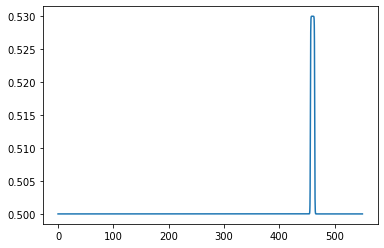

In [9]:
plot(Ts, waveform2)

In [10]:
result = mesolve(H_full, rho0, Ts, 
                 c_ops = [],e_ops = [sigma_z1_chain],progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-3))

10.0%. Run time:   7.05s. Est. time left: 00:00:01:03
20.0%. Run time:  14.02s. Est. time left: 00:00:00:56
30.0%. Run time:  20.98s. Est. time left: 00:00:00:48
40.0%. Run time:  27.95s. Est. time left: 00:00:00:41
50.0%. Run time:  34.95s. Est. time left: 00:00:00:34
60.0%. Run time:  41.89s. Est. time left: 00:00:00:27
70.0%. Run time:  48.87s. Est. time left: 00:00:00:20
80.0%. Run time:  55.84s. Est. time left: 00:00:00:13
90.0%. Run time:  62.82s. Est. time left: 00:00:00:06
Total run time:  69.79s


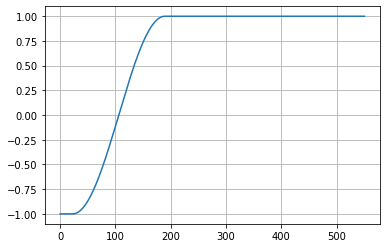

In [11]:
plot(Ts, result.expect[0])
grid()

In [12]:
H_tr1 = chain._build_transmon_H_at_index(0, waveform1)

In [13]:
H_tr1[2][1]

array([1., 1., 1., ..., 1., 1., 1.])

In [14]:
H_dr = chain.build_RWA_driving(params,[[T._pi_duration/2,0],[0,0],[0,0],[0,0]])

/home/alexeitolstobrov/server/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [15]:
H_dr[0][0]

Quantum object: dims = [[15], [15]], shape = (15, 15), type = oper, isherm = True
Qobj data =
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         1.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.  

In [16]:
H_int = chain.Hint_RF_RWA(1,2,0.02)